In [1]:
! module load ffmpeg
import os
import re 
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
import cartopy.crs as ccrs

plt.rcParams['animation.ffmpeg_path'] ='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg'

In [2]:
from dask.distributed import Client
client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43624,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:43149,Total threads: 2
Dashboard: http://127.0.0.1:43187/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:39154,


In [4]:
NAME = 'mima_jan'
FILE = 'mima_jan'

In [8]:
BASE_DIR_AM4 = "/scratch/users/robcking/am4_error_growth/"
BASE_DIR_MIMA = "/scratch/users/robcking/mima_predictability/jan"

BASE_DIR = BASE_DIR_MIMA # N.B this is for Jan at the moment 

## load in runs

In [11]:
import re 
perturbed_memberlist = sorted(filter(lambda x: re.match(r'.+\/[0-9]+\/atmos_4xdaily.nc',x),glob(os.path.join(BASE_DIR,'*','atmos_4xdaily.nc'))),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
perturbed_ds =  xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks={'time':10,'pfull':'auto'},decode_times=False)

In [12]:
perturbed_ds

<xarray.Dataset> Size: 29GB
Dimensions:  (members: 20, time: 360, pfull: 40, lat: 64, lon: 128, phalf: 41,
              lonb: 129, latb: 65)
Coordinates:
  * lon      (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb     (lonb) float32 516B -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
  * lat      (lat) float32 256B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * latb     (latb) float32 260B -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * pfull    (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
  * phalf    (phalf) float32 164B 0.0 0.4844 0.6312 0.8205 ... 863.5 941.4 1e+03
  * time     (time) float64 3kB 1.8e+03 1.8e+03 1.801e+03 ... 1.89e+03 1.89e+03
Dimensions without coordinates: members
Data variables:
    ucomp    (members, time, pfull, lat, lon) float32 9GB dask.array<chunksize=(1, 10, 40, 64, 128), meta=np.ndarray>
    vcomp    (members, time, pfull, lat, lon) float32 9GB dask.array<chunksize=(1, 10, 40, 64, 128), meta=np.ndarray>
    temp     (members, time, pfull, lat, lon) float32 9GB dask.array<chunksize=(1, 10, 40, 64, 128), meta=np.ndarray>
    olr      (members, time, lat, lon) float32 236MB dask.array<chunksize=(1, 10, 64, 128), meta=np.ndarray>
    bk       (members, phalf) float32 3kB dask.array<chunksize=(1, 41), meta=np.ndarray>
    pk       (members, phalf) float32 3kB dask.array<chunksize=(1, 41), meta=np.ndarray>
    ps       (members, time, lat, lon) float32 236MB dask.array<chunksize=(1, 10, 64, 128), meta=np.ndarray>
Attributes:
    filename:  atmos_4xdaily.nc
    title:     MiMA

In [13]:
ctl_path = os.path.join(BASE_DIR,'ctl','atmos_4xdaily.nc')
ctl = xr.open_dataset(ctl_path,chunks={'time':10,'pfull':'auto'},decode_times=False)
ctl

<xarray.Dataset> Size: 1GB
Dimensions:  (lon: 128, lonb: 129, lat: 64, latb: 65, pfull: 40, phalf: 41,
              time: 360)
Coordinates:
  * lon      (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb     (lonb) float32 516B -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
  * lat      (lat) float32 256B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * latb     (latb) float32 260B -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * pfull    (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
  * phalf    (phalf) float32 164B 0.0 0.4844 0.6312 0.8205 ... 863.5 941.4 1e+03
  * time     (time) float64 3kB 1.8e+03 1.8e+03 1.801e+03 ... 1.89e+03 1.89e+03
Data variables:
    ucomp    (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    vcomp    (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    temp     (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    olr      (time, lat, lon) float32 12MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
    bk       (phalf) float32 164B dask.array<chunksize=(41,), meta=np.ndarray>
    pk       (phalf) float32 164B dask.array<chunksize=(41,), meta=np.ndarray>
    ps       (time, lat, lon) float32 12MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
Attributes:
    filename:  atmos_4xdaily.nc
    title:     MiMA

In [37]:
ctl.ucomp.mean(dim='time').min(dim='lon').max(dim='lat').mean()

<xarray.DataArray 'ucomp' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

### reference diagnostic profile

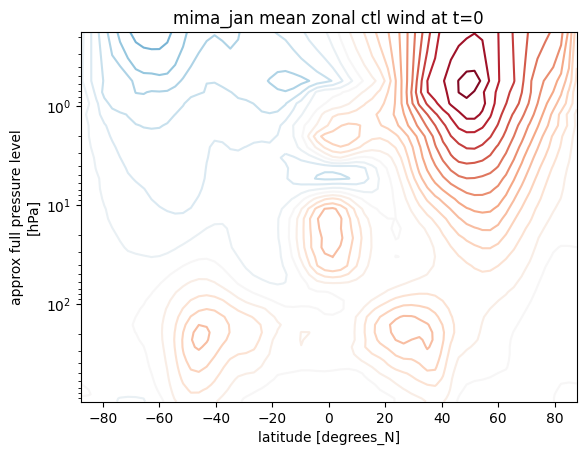

In [14]:
ctl.ucomp.isel(time=0).mean(dim=['lon']).plot.contour(x='lat',y='pfull',levels=30,yincrease=False,yscale='log')
plt.gca().set_title(f'{NAME} mean zonal ctl wind at t=0') 
plt.savefig(f"{NAME}/{NAME}_u_xsection_ctl.png")


In [15]:
Rcp = 0.286 # R/cp for dry atmosphere
ctl_pt = ctl.temp*(1000/ctl.pfull)**(Rcp)

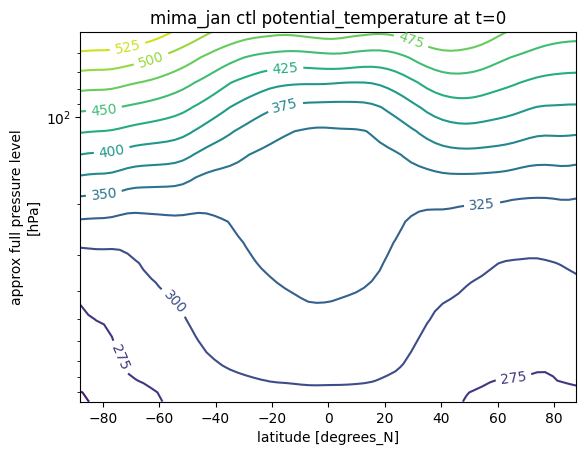

In [16]:
contour = ctl_pt.sel(pfull=slice(50,None)).isel(time=0).mean(dim=('lon')).plot.contour(x='lat',y='pfull',levels=15,yincrease=False,yscale='log')
plt.clabel(contour, contour.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} ctl potential_temperature at t=0")
plt.savefig(f"{NAME}/{NAME}_ctl_potential_temp.png")

## Plot Ensemble Member history
Here RMSE is RMSE = np.sqrt((members - ref)) for ref=0 FOR ALL members 


In [18]:
square_residual = (perturbed_ds- ctl)**2
eq = np.sqrt(square_residual['ucomp'].sel(lat=slice(-10,10)).sel(pfull=850,method='nearest').mean(dim=("lon", "lat")))
midlat = np.sqrt(square_residual['ucomp'].sel(lat=slice(30,60)).sel(pfull=850,method='nearest').mean(dim=("lon", "lat")))
polar = np.sqrt(square_residual['ucomp'].sel(lat=slice(60,90)).sel(pfull=850,method='nearest').mean(dim=("lon", "lat")))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


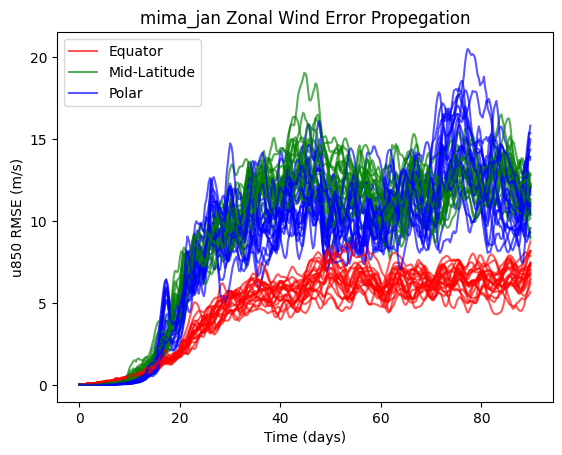

In [19]:
fig,ax = plt.subplots()
x = np.arange(0,len(ctl.time)*0.25,0.25)
for i in range(len(perturbed_memberlist)):
    print(i)
    ax.plot(x,eq.isel(members=i).values,alpha=0.65,color='red',label='Equator' if not i else None)
    ax.plot(x,midlat.isel(members=i).values,alpha=0.65,color='green',label='Mid-Latitude' if not i else None)
    ax.plot(x,polar.isel(members=i).values,alpha=0.65,color='blue',label='Polar' if not i else None)
ax.legend()
ax.set_ylabel("u850 RMSE (m/s)")
ax.set_xlabel("Time (days)")
ax.set_title(f"{NAME} Zonal Wind Error Propegation")
ax.legend()
plt.savefig(f'{NAME}/{NAME}_mean_u850_error_sat.png')

## Error Doubling

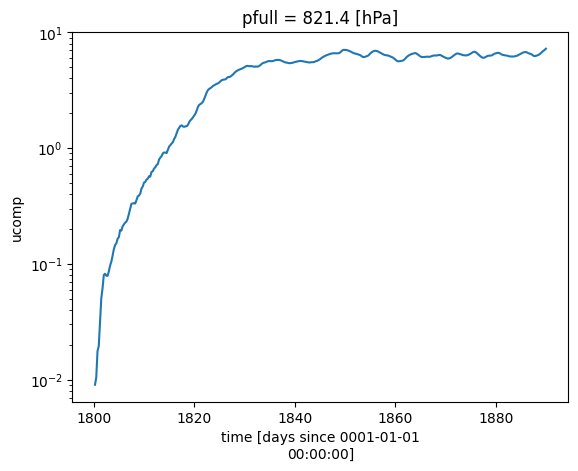

In [28]:
eq.mean(dim='members').plot(yscale='log')

## Max error

In [17]:
rmse = np.sqrt(square_residual.mean(dim='members'))

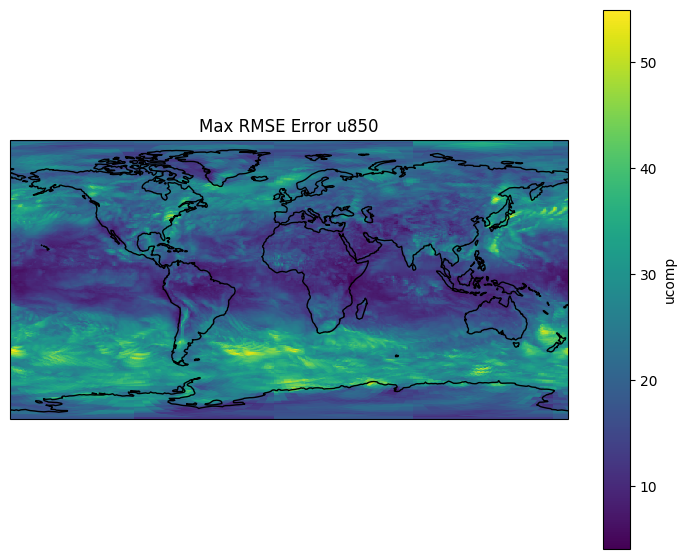

In [18]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree())
rmse.ucomp.sel(pfull=850,method='nearest').max(dim='time').plot.pcolormesh(ax=ax)
ax.coastlines()
ax.set_title("Max RMSE Error u850")
plt.savefig(f'{NAME}/{NAME}_max_rmse_u850.png')

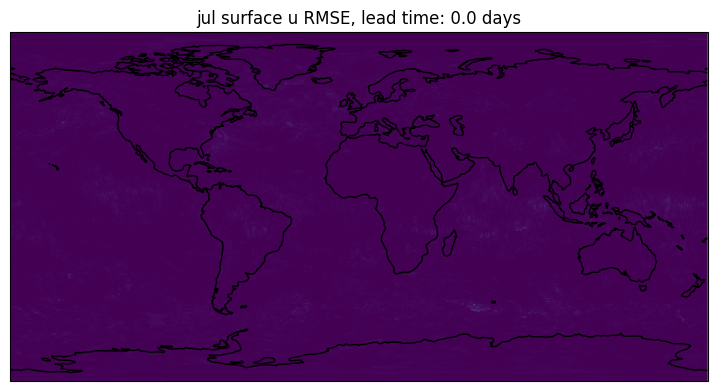

In [19]:
from matplotlib.animation import FuncAnimation

rmse_avg = rmse
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
#im = rmse_avg.u_ref.isel(time=0).plot.imshow(ax=ax,vmin=0,vmax=20,transform=ccrs.PlateCarree(central_longitude=180),animated=True)
ax.pcolormesh(rmse_avg.grid_xt,rmse_avg.grid_yt,rmse_avg.u_ref.isel(time=0),vmin=0,vmax=20,transform=ccrs.PlateCarree(),)
ax.coastlines()

def animate(i):
    # rmse_avg.u_ref.isel(time=0).plot.imshow(ax=ax,vmin=0,vmax=20,transform=ccrs.PlateCarree(central_longitude=180),animated=True)
    ax.set_title(f"{NAME} surface u RMSE, lead time: {i/4} days")
    ax.pcolormesh(rmse_avg.grid_xt,rmse_avg.grid_yt,rmse_avg.u_ref.isel(time=i),vmin=0,vmax=20,transform=ccrs.PlateCarree(),)
ani = FuncAnimation(fig,animate,frames=100,blit=False)

In [20]:
ani.save(f'{NAME}/{NAME}_usrf_error_growth.mp4')

### horizontal time to error propegation

In [21]:
ROLLING_AVG_DAYS = 10
AM4_THRESHOLD = 0.03

In [22]:
rolling_avg = rmse.rolling(dim={'time':4*ROLLING_AVG_DAYS},center=True).mean()
rel_diff = (rolling_avg.isel(time=slice(1,None)) - rolling_avg.isel(time=slice(-1)))/(rolling_avg.isel(time=slice(-1)))
tts = ((rolling_avg > rolling_avg.mean(dim='time')*0.5) & (rel_diff < AM4_THRESHOLD))[['ucomp','u_ref','v_ref','vcomp','temp','hght','precip','olr']].argmax(dim='time')*6/24


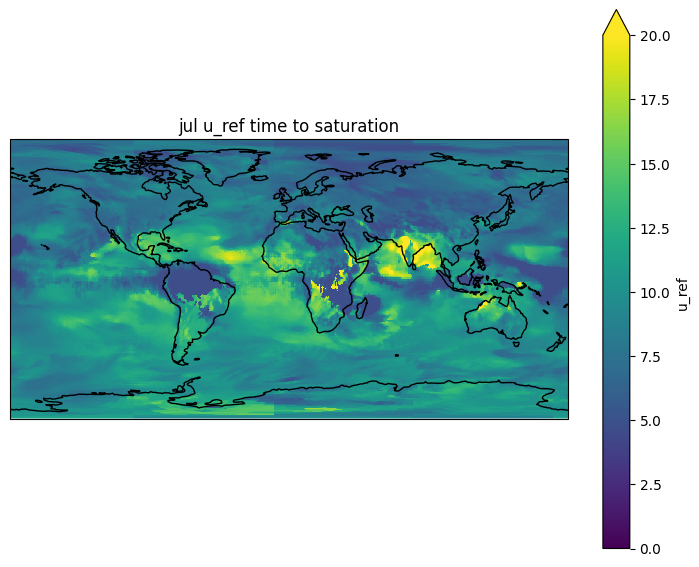

In [23]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree())
tts.u_ref.plot.pcolormesh(ax=ax,vmax=20,vmin=0)
ax.coastlines()
ax.set_title(f"{NAME} u_ref time to saturation")
plt.savefig(f'{NAME}/{NAME}_u_ref_tts.png')

### Error Propegation zonal vs p

In [24]:
zonal_rmse = rmse.mean(dim=('grid_xt')).sel(pfull=slice(1,None))
zonal_rmse = zonal_rmse.rolling(dim={'time':4*ROLLING_AVG_DAYS},center=True).mean()
rel_diff = (zonal_rmse.isel(time=slice(1,None)) - zonal_rmse.isel(time=slice(-1)))/(zonal_rmse.isel(time=slice(-1)))
zonal_tts = ((zonal_rmse > zonal_rmse.mean(dim='time')*0.5) & (rel_diff < AM4_THRESHOLD))[['ucomp','vcomp','temp','hght']]
zonal_tts = (zonal_tts.argmax(dim='time')*6)/24
zonal_tts.to_netcdf(f'/scratch/users/robcking/am4_error_growth_full/{NAME}_zonal_tts.nc')

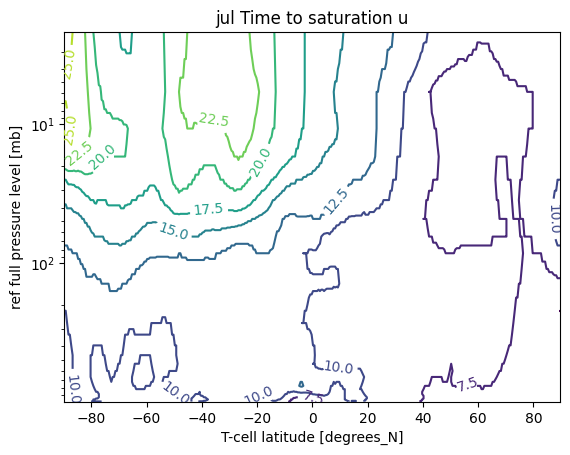

In [25]:
CS = zonal_tts.ucomp.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation u")
plt.savefig(f"{NAME}/{NAME}_tts_ucomp_pvlat.png")

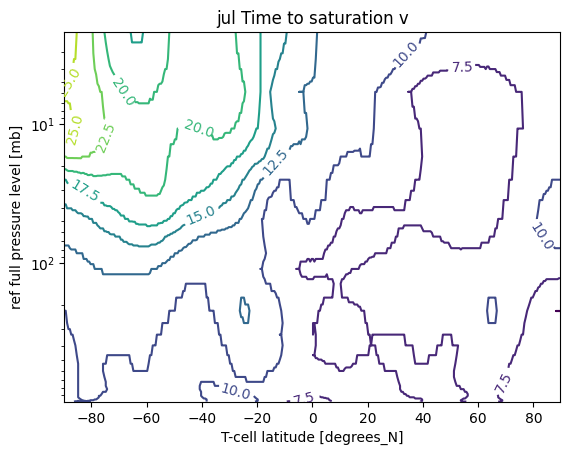

In [26]:
CS = zonal_tts.vcomp.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation v")
plt.savefig(f"{NAME}/{NAME}_tts_vcomp_pvlat.png")

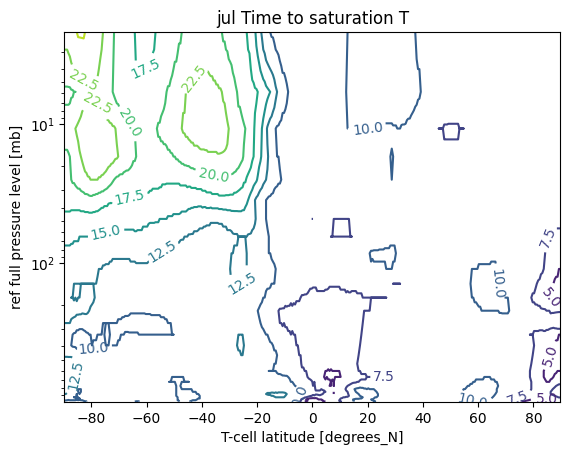

In [27]:
CS = zonal_tts.temp.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation T")
plt.savefig(f"{NAME}/{NAME}_tts_temp_pvlat.png")

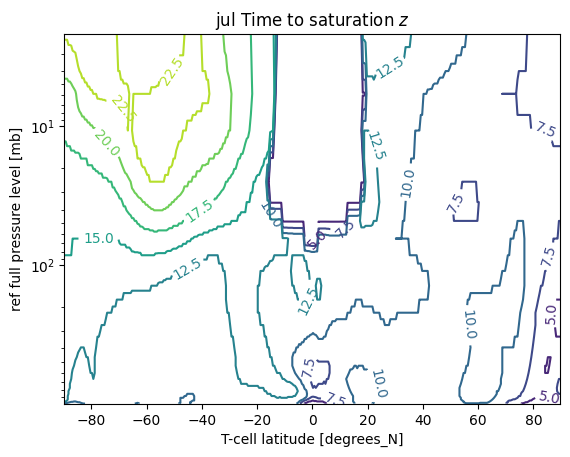

In [28]:
CS = zonal_tts.hght.plot.contour(levels=10,x='grid_yt',y='pfull',yincrease=False,yscale='log')
plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.gca().set_title(f"{NAME} Time to saturation $z$")
plt.savefig(f"{NAME}/{NAME}_tts_z_pvlat.png")

In [29]:
perturbed_ds.precip

<xarray.DataArray 'precip' (members: 5, time: 368, grid_yt: 360, grid_xt: 576)> Size: 2GB
dask.array<concatenate, shape=(5, 368, 360, 576), dtype=float32, chunksize=(1, 10, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 3kB 1979-07-01 06:00:00 ... 1979-10-01 00:00:00
  * grid_yt  (grid_yt) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * grid_xt  (grid_xt) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
Dimensions without coordinates: members
Attributes:
    units:          kg/m2/s
    long_name:      Total precipitation rate
    cell_methods:   time: point
    interp_method:  conserve_order1

Text(0.5, 1.0, 'jul max ensemble precip')

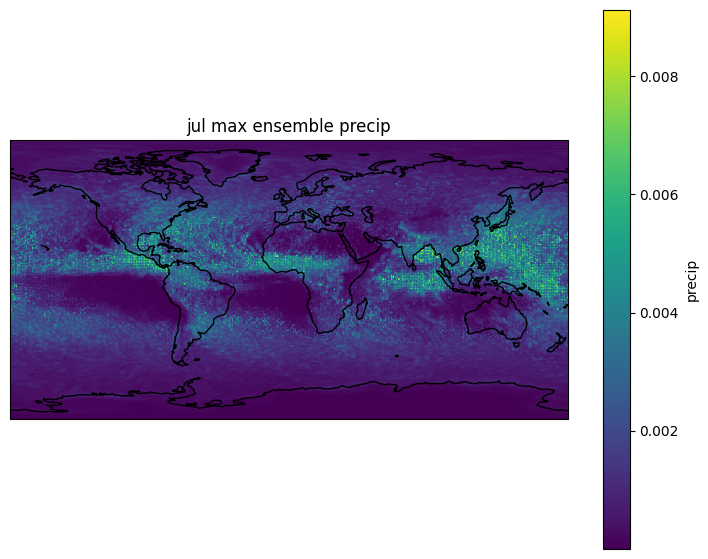

In [30]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree())
perturbed_ds.precip.max(dim=('members','time')).plot.pcolormesh(ax=ax)
ax.coastlines()
ax.set_title(f"{NAME} max ensemble precip")


/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/robcking/experiments/error_sat/env/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


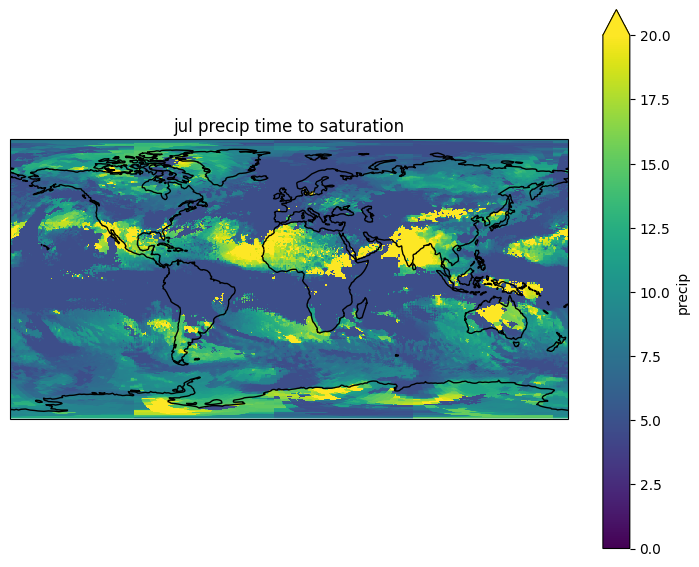

In [31]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree())
tts.precip.plot.pcolormesh(ax=ax,vmax=20,vmin=0)
ax.coastlines()
ax.set_title(f"{NAME} precip time to saturation")
plt.savefig(f'{NAME}/{NAME}_precip_tts.png')

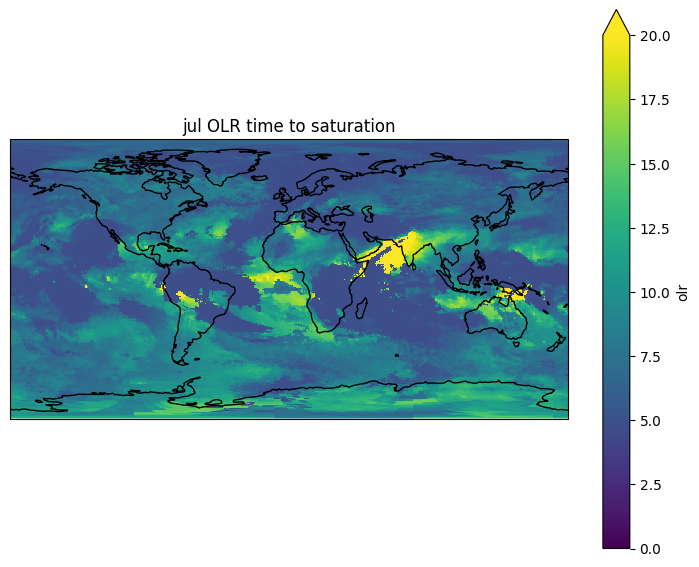

In [32]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection=ccrs.PlateCarree())
tts.olr.plot.pcolormesh(ax=ax,vmax=20,vmin=0)
ax.coastlines()
ax.set_title(f"{NAME} OLR time to saturation")
plt.savefig(f'{NAME}/{NAME}_olr_tts.png')